In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import optuna
import optuna.visualization as vis
from sklearn.pipeline import Pipeline
from mrmr import mrmr_regression

# Set random seed for reproducibility
np.random.seed(42)

# Import and Prepare Data

In [2]:
# Load the data
file_path = "features-Master.csv"
data = pd.read_csv(file_path)

# Shuffle the data
shuffled = data.sample(frac=1, random_state=42).reset_index(drop=True)
data_shuffled = shuffled.iloc[:, 4:]
labels_shuffled = shuffled["Comfort Score"]

# Class to Accomodate MRMR Feature Selection Structure

In [3]:
class MRMRTransformer:
    def __init__(self, k_features):
        self.k_features = k_features
        self.selected_features = None
        self.column_names = None
    
    def fit(self, X, y):
        # Convert to DataFrame if not already
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        
        # Reset indices to avoid alignment issues
        X = X.reset_index(drop=True)
        y = pd.Series(y).reset_index(drop=True)
        
        self.column_names = X.columns.tolist()
        try:
            self.selected_features = mrmr_regression(X, y, K=self.k_features)
            print("Got MRMR features")
        except:
            # Fallback to random features if MRMR fails
            self.selected_features = np.random.choice(X.columns, size=min(self.k_features, len(X.columns)), replace=False)
            print("MRMR failed, selected random features instead.")
        return self
    
    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.column_names)
        return X[self.selected_features]

# Train/Test Split

In [4]:
# For regression (using stratified split based on binned target)
X_train, X_test, y_train, y_test = train_test_split(
    data_shuffled, 
    labels_shuffled, 
    test_size=0.2, 
    stratify=labels_shuffled,
    random_state=42
)

# Optimize Feature Selection and Catboost Parameters

In [ ]:
X = X_train.copy()
y = y_train.copy().values

def objective(trial):
    # 1. Feature Selection
    fs_method = trial.suggest_categorical('feature_selection', ['RFE', 'MRMR', 'None'])
    if fs_method != 'None':
        k_features = trial.suggest_int('k_features', 5, 105, step = 10) 
        if fs_method == 'RFE':
            #rfe_step = trial.suggest_float('rfe_step', 0.1, 1.0, step=0.1) #### Can edit step size. This is the fraction of features to remove at each iteration of feature elimination https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html
            estimator = RandomForestRegressor()
                #n_estimators=trial.suggest_int('rfe_n_estimators', 50, 200),
                #max_depth=trial.suggest_int('rfe_max_depth', 3, 10),
                #random_state=42
            selector = RFE(estimator, n_features_to_select=k_features)
        elif fs_method == 'MRMR':
            selector = MRMRTransformer(k_features=k_features) #https://feature-engine.trainindata.com/en/1.8.x/api_doc/selection/MRMR.html#feature_engine.selection.MRMR
    else:
        selector = 'passthrough'

    # 2. CatBoost Parameters
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000, step=25),
        'depth': trial.suggest_int('depth', 6, 10), #https://catboost.ai/docs/en/concepts/parameter-tuning
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True), #https://forecastegy.com/posts/catboost-hyperparameter-tuning-guide-with-optuna/
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True), 
        'random_strength': trial.suggest_float('random_strength', 1e-9, 10, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'random_seed': 42,
        'verbose': False,
    }
    model = CatBoostRegressor(**params)

    # 3. Pipeline 
    pipeline = Pipeline([
        ('feature_selection', selector),
        ('model', model)
    ])

    #4. Cross-validation
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    try:
        scores = cross_val_score(pipeline, X, y, cv=cv, scoring='r2', n_jobs=1)
        return np.mean(scores)
    except Exception:
        return -np.inf

# Run Optuna Study
study = optuna.create_study(direction='maximize') # sampler = optuna.samplers.QMCSampler()) https://optuna.readthedocs.io/en/stable/reference/samplers/generated/optuna.samplers.QMCSampler.html#optuna.samplers.QMCSampler
study.optimize(objective, n_trials=200, show_progress_bar=True, n_jobs=6) 

# Best result
print("Best trial:")
trial = study.best_trial
print(f"R²: {trial.value:.4f}")
print("Params: ")
for key, value in trial.params.items():
    print(f"  {key}: {value}")

[I 2025-08-28 15:04:33,777] A new study created in memory with name: no-name-3c1cf9b7-d2a5-4141-9d74-761989dad2a8


  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 35/35 [00:05<00:00,  5.88it/s]


Got MRMR features


100%|██████████| 35/35 [00:05<00:00,  6.15it/s]


Got MRMR features


100%|██████████| 35/35 [00:05<00:00,  6.01it/s]


Got MRMR features


100%|██████████| 35/35 [00:05<00:00,  6.37it/s]


Got MRMR features
[I 2025-08-28 15:06:36,178] Trial 5 finished with value: 0.05712638439725637 and parameters: {'feature_selection': 'None', 'iterations': 300, 'depth': 8, 'learning_rate': 0.004370024779229983, 'l2_leaf_reg': 6.884294468911514, 'random_strength': 4.751476377625162, 'bagging_temperature': 0.5545587057783081, 'border_count': 55}. Best is trial 5 with value: 0.05712638439725637.





































100%|██████████| 35/35 [00:07<00:00,  4.50it/s]


Got MRMR features


100%|██████████| 75/75 [00:13<00:00,  5.49it/s]


Got MRMR features
[I 2025-08-28 15:06:56,727] Trial 3 finished with value: 0.1327032225890585 and parameters: {'feature_selection': 'MRMR', 'k_features': 35, 'iterations': 400, 'depth': 8, 'learning_rate': 0.005879940007129575, 'l2_leaf_reg': 4.7361946572641264e-07, 'random_strength': 9.271456571428316e-05, 'bagging_temperature': 0.2575896142905243, 'border_count': 44}. Best is trial 3 with value: 0.1327032225890585.


100%|██████████| 55/55 [00:08<00:00,  6.20it/s]


Got MRMR features


100%|██████████| 75/75 [00:11<00:00,  6.40it/s]


Got MRMR features


100%|██████████| 55/55 [00:08<00:00,  6.11it/s]


Got MRMR features












                                        
                                            


 45%|████▌     | 34/75 [00:06<00:11,  3.62it/s]

[I 2025-08-28 15:08:25,076] Trial 0 finished with value: 0.1862114783217204 and parameters: {'feature_selection': 'None', 'iterations': 825, 'depth': 7, 'learning_rate': 0.003428982345374868, 'l2_leaf_reg': 3.316086722637091, 'random_strength': 5.017939551564244e-08, 'bagging_temperature': 0.3003132503131485, 'border_count': 47}. Best is trial 0 with value: 0.1862114783217204.












































100%|██████████| 75/75 [00:16<00:00,  4.65it/s]



 96%|█████████▋| 53/55 [00:12<00:00,  4.98it/s]

Got MRMR features




100%|██████████| 55/55 [00:12<00:00,  4.33it/s]


Got MRMR features













































100%|██████████| 55/55 [00:12<00:00,  4.41it/s]



Got MRMR features





























100%|██████████| 75/75 [00:14<00:00,  5.05it/s]


Got MRMR features



































100%|██████████| 55/55 [00:11<00:00,  4.64it/s]



Got MRMR features



































100%|██████████| 75/75 [00:13<00:00,  5.37it/s]


Got MRMR features
[I 2025-08-28 15:10:49,597] Trial 7 finished with value: 0.15417260494917132 and parameters: {'feature_selection': 'MRMR', 'k_features': 55, 'iterations': 975, 'depth': 7, 'learning_rate': 0.06559561706729869, 'l2_leaf_reg': 1.0093249823831954e-07, 'random_strength': 0.06211184276769817, 'bagging_temperature': 0.3258785361271972, 'border_count': 135}. Best is trial 0 with value: 0.1862114783217204.
[I 2025-08-28 15:11:00,712] Trial 6 finished with value: 0.20063172131907664 and parameters: {'feature_selection': 'MRMR', 'k_features': 75, 'iterations': 575, 'depth': 8, 'learning_rate': 0.006894760874655682, 'l2_leaf_reg': 2.5180128763821754e-07, 'random_strength': 0.011452549723626729, 'bagging_temperature': 0.2668457061863564, 'border_count': 169}. Best is trial 6 with value: 0.20063172131907664.
[I 2025-08-28 15:23:46,546] Trial 9 finished with value: 0.19417362148187864 and parameters: {'feature_selection': 'None', 'iterations': 400, 'depth': 9, 'learning_rate': 0.01

100%|██████████| 95/95 [00:04<00:00, 19.83it/s]


Got MRMR features


100%|██████████| 95/95 [00:05<00:00, 18.70it/s]


Got MRMR features


100%|██████████| 95/95 [00:05<00:00, 17.97it/s]


Got MRMR features


100%|██████████| 95/95 [00:05<00:00, 17.26it/s]


Got MRMR features


100%|██████████| 95/95 [00:06<00:00, 15.80it/s]


Got MRMR features
[I 2025-08-28 15:47:22,330] Trial 13 finished with value: 0.17168524673237634 and parameters: {'feature_selection': 'MRMR', 'k_features': 95, 'iterations': 425, 'depth': 10, 'learning_rate': 0.02486077452025475, 'l2_leaf_reg': 1.7699380223559938e-07, 'random_strength': 0.02604162810808403, 'bagging_temperature': 0.07898636710184137, 'border_count': 76}. Best is trial 11 with value: 0.20185336852887686.
[I 2025-08-28 16:18:15,186] Trial 8 finished with value: 0.155408355394164 and parameters: {'feature_selection': 'RFE', 'k_features': 105, 'iterations': 425, 'depth': 10, 'learning_rate': 0.021793662373950973, 'l2_leaf_reg': 0.00038523995747921625, 'random_strength': 5.909156962064537, 'bagging_temperature': 0.6550553470590299, 'border_count': 169}. Best is trial 11 with value: 0.20185336852887686.
[I 2025-08-28 16:20:06,224] Trial 4 finished with value: -0.08531121972769093 and parameters: {'feature_selection': 'RFE', 'k_features': 5, 'iterations': 625, 'depth': 7, 'le

100%|██████████| 75/75 [00:12<00:00,  5.99it/s]


Got MRMR features


[I 2025-08-28 16:21:00,890] Trial 10 finished with value: 0.16864222990090755 and parameters: {'feature_selection': 'RFE', 'k_features': 75, 'iterations': 325, 'depth': 10, 'learning_rate': 0.06766272334785786, 'l2_leaf_reg': 0.04616596975467312, 'random_strength': 0.009223024608250786, 'bagging_temperature': 0.22005341852531335, 'border_count': 246}. Best is trial 11 with value: 0.20185336852887686.





























100%|██████████| 75/75 [00:11<00:00,  6.38it/s]



Got MRMR features












100%|██████████| 65/65 [00:06<00:00, 10.34it/s]


Got MRMR features
















































100%|██████████| 65/65 [00:07<00:00,  8.25it/s]




Got MRMR features






100%|██████████| 75/75 [00:08<00:00,  8.75it/s]


Got MRMR features





























100%|██████████| 65/65 [00:06<00:00, 10.63it/s]



Got MRMR features












100%|██████████| 75/75 [00:06<00:00, 12.01it/s]


Got MRMR features

























100%|██████████| 65/65 [00:05<00:00, 10.84it/s]




Got MRMR features















100%|██████████| 75/75 [00:06<00:00, 11.67it/s]


Got MRMR features


[I 2025-08-28 16:21:51,313] Trial 16 finished with value: 0.1506850968695995 and parameters: {'feature_selection': 'MRMR', 'k_features': 75, 'iterations': 650, 'depth': 6, 'learning_rate': 0.001390399651528827, 'l2_leaf_reg': 1.0962131513982021e-05, 'random_strength': 2.019506207046737e-06, 'bagging_temperature': 0.011866723342403573, 'border_count': 213}. Best is trial 11 with value: 0.20185336852887686.


100%|██████████| 65/65 [00:05<00:00, 11.06it/s]


Got MRMR features
[I 2025-08-28 16:22:00,805] Trial 17 finished with value: 0.12640784601275457 and parameters: {'feature_selection': 'MRMR', 'k_features': 65, 'iterations': 675, 'depth': 6, 'learning_rate': 0.0010499031919548353, 'l2_leaf_reg': 6.452207256172463e-06, 'random_strength': 7.748260784464418e-07, 'bagging_temperature': 0.01650212799971862, 'border_count': 110}. Best is trial 11 with value: 0.20185336852887686.
[I 2025-08-28 16:22:12,361] Trial 18 finished with value: 0.0776966113723672 and parameters: {'feature_selection': 'None', 'iterations': 125, 'depth': 6, 'learning_rate': 0.0021061475866996165, 'l2_leaf_reg': 1.9707345694928476e-05, 'random_strength': 3.3367425038937552e-09, 'bagging_temperature': 0.14842553889778498, 'border_count': 106}. Best is trial 11 with value: 0.20185336852887686.
[I 2025-08-28 16:26:17,732] Trial 19 finished with value: 0.09460174892720412 and parameters: {'feature_selection': 'None', 'iterations': 175, 'depth': 9, 'learning_rate': 0.0024203

100%|██████████| 35/35 [00:07<00:00,  4.48it/s]


Got MRMR features


100%|██████████| 35/35 [00:07<00:00,  4.49it/s]


Got MRMR features


[I 2025-08-28 16:28:07,649] Trial 1 finished with value: 0.07023836213568639 and parameters: {'feature_selection': 'RFE', 'k_features': 5, 'iterations': 725, 'depth': 6, 'learning_rate': 0.0057271555210616654, 'l2_leaf_reg': 6.8003016225519064e-06, 'random_strength': 8.137161676616211e-08, 'bagging_temperature': 0.7863596550083249, 'border_count': 234}. Best is trial 11 with value: 0.20185336852887686.














100%|██████████| 35/35 [00:08<00:00,  3.97it/s]



Got MRMR features
























100%|██████████| 35/35 [00:09<00:00,  3.73it/s]


Got MRMR features

















100%|██████████| 35/35 [00:09<00:00,  3.83it/s]



Got MRMR features





















100%|██████████| 35/35 [00:10<00:00,  3.37it/s]


Got MRMR features













100%|██████████| 35/35 [00:09<00:00,  3.88it/s]



Got MRMR features

























100%|██████████| 35/35 [00:10<00:00,  3.29it/s]


Got MRMR features
[I 2025-08-28 16:30:30,448] Trial 21 finished with value: 0.16143759822235865 and parameters: {'feature_selection': 'MRMR', 'k_features': 35, 'iterations': 800, 'depth': 8, 'learning_rate': 0.007874561254582548, 'l2_leaf_reg': 0.0004345838570521158, 'random_strength': 0.7550134745819501, 'bagging_temperature': 0.40381436736063325, 'border_count': 193}. Best is trial 11 with value: 0.20185336852887686.


100%|██████████| 35/35 [00:09<00:00,  3.81it/s]


Got MRMR features


100%|██████████| 35/35 [00:09<00:00,  3.51it/s]


Got MRMR features
[I 2025-08-28 16:32:52,082] Trial 22 finished with value: 0.15231214878081503 and parameters: {'feature_selection': 'MRMR', 'k_features': 35, 'iterations': 550, 'depth': 8, 'learning_rate': 0.007294267269739802, 'l2_leaf_reg': 0.00022158354608989224, 'random_strength': 0.3824039728057108, 'bagging_temperature': 0.426993247298479, 'border_count': 200}. Best is trial 11 with value: 0.20185336852887686.
[I 2025-08-28 16:40:58,928] Trial 20 finished with value: 0.19552911478657936 and parameters: {'feature_selection': 'None', 'iterations': 775, 'depth': 9, 'learning_rate': 0.007130129700394242, 'l2_leaf_reg': 1.9243836893944384e-06, 'random_strength': 0.0005932645623587903, 'bagging_temperature': 0.3808593520309267, 'border_count': 170}. Best is trial 11 with value: 0.20185336852887686.
[I 2025-08-28 16:41:21,699] Trial 24 finished with value: 0.2045683421504556 and parameters: {'feature_selection': 'None', 'iterations': 550, 'depth': 7, 'learning_rate': 0.017922848929618
































100%|██████████| 45/45 [00:08<00:00,  5.35it/s]




Got MRMR features













100%|██████████| 45/45 [00:07<00:00,  5.72it/s]


Got MRMR features


[I 2025-08-28 17:52:51,943] Trial 61 finished with value: 0.15343632370290494 and parameters: {'feature_selection': 'None', 'iterations': 450, 'depth': 7, 'learning_rate': 0.003713402512000652, 'l2_leaf_reg': 4.1570321686954805e-08, 'random_strength': 2.0736945710648835, 'bagging_temperature': 0.7327296297516499, 'border_count': 183}. Best is trial 53 with value: 0.21050298478709478.































100%|██████████| 45/45 [00:12<00:00,  3.73it/s]







Got MRMR features






100%|██████████| 45/45 [00:11<00:00,  3.85it/s]







Got MRMR features


 31%|███       | 14/45 [00:03<00:05,  5.44it/s]





























































100%|██████████| 45/45 [00:08<00:00,  5.49it/s]


Got MRMR features



































































































































100%|██████████| 45/45 [00:15<00:00,  2.89it/s]





100%|██████████| 45/45 [00:15<00:00,  3.66it/s]

Got MRMR features


100%|██████████| 45/45 [00:15<00:00,  2.92it/s]


100%|██████████| 45/45 [00:15<00:00,  2.95it/s]


Got MRMR features
Got MRMR features










































100%|██████████| 45/45 [00:09<00:00,  4.55it/s]




Got MRMR features























































































100%|██████████| 45/45 [00:09<00:00,  4.95it/s]




Got MRMR features








100%|██████████| 45/45 [00:08<00:00,  5.53it/s]


Got MRMR features


100%|██████████| 45/45 [00:07<00:00,  6.03it/s]


Got MRMR features














































































100%|██████████| 45/45 [00:11<00:00,  3.85it/s]






Got MRMR features





100%|██████████| 45/45 [00:11<00:00,  3.85it/s]






Got MRMR features


















































100%|██████████| 45/45 [00:09<00:00,  4.54it/s]


Got MRMR features
[I 2025-08-28 17:55:07,465] Trial 65 finished with value: 0.16026042875214241 and parameters: {'feature_selection': 'MRMR', 'k_features': 45, 'iterations': 575, 'depth': 8, 'learning_rate': 0.01410588617282486, 'l2_leaf_reg': 2.2414145602807066e-05, 'random_strength': 0.009693252435730588, 'bagging_temperature': 0.3500393032837754, 'border_count': 83}. Best is trial 53 with value: 0.21050298478709478.
[I 2025-08-28 17:55:10,510] Trial 63 finished with value: 0.16088316154092228 and parameters: {'feature_selection': 'MRMR', 'k_features': 45, 'iterations': 575, 'depth': 8, 'learning_rate': 0.0037815614941346613, 'l2_leaf_reg': 1.5799745892110102e-08, 'random_strength': 2.8199311690872935, 'bagging_temperature': 0.7691346689313228, 'border_count': 179}. Best is trial 53 with value: 0.21050298478709478.
[I 2025-08-28 17:55:12,023] Trial 64 finished with value: 0.16405859369002548 and parameters: {'feature_selection': 'MRMR', 'k_features': 45, 'iterations': 575, 'depth': 8



















100%|██████████| 25/25 [00:04<00:00,  5.26it/s]




Got MRMR features






100%|██████████| 25/25 [00:03<00:00,  7.12it/s]


Got MRMR features


100%|██████████| 25/25 [00:03<00:00,  8.02it/s]


Got MRMR features


[I 2025-08-28 18:21:51,669] Trial 103 finished with value: 0.20673254955443365 and parameters: {'feature_selection': 'None', 'iterations': 925, 'depth': 6, 'learning_rate': 0.00341114016307249, 'l2_leaf_reg': 5.5666826593038785e-06, 'random_strength': 0.5590438745662799, 'bagging_temperature': 0.6443786644212375, 'border_count': 89}. Best is trial 92 with value: 0.22206174374997997.


100%|██████████| 25/25 [00:03<00:00,  8.01it/s]


Got MRMR features


100%|██████████| 25/25 [00:03<00:00,  7.66it/s]


Got MRMR features


100%|██████████| 25/25 [00:03<00:00,  7.53it/s]


Got MRMR features


100%|██████████| 25/25 [00:02<00:00,  8.99it/s]


Got MRMR features


[I 2025-08-28 18:22:14,558] Trial 101 finished with value: 0.2198013536105612 and parameters: {'feature_selection': 'None', 'iterations': 925, 'depth': 6, 'learning_rate': 0.005374539212483786, 'l2_leaf_reg': 5.602114370435353e-06, 'random_strength': 0.5537965464114197, 'bagging_temperature': 0.6911498786642323, 'border_count': 88}. Best is trial 92 with value: 0.22206174374997997.


 48%|████▊     | 12/25 [00:01<00:02,  5.85it/s]




100%|██████████| 25/25 [00:04<00:00,  6.10it/s]



Got MRMR features
















100%|██████████| 25/25 [00:03<00:00,  6.73it/s]


Got MRMR features


[I 2025-08-28 18:22:21,937] Trial 104 finished with value: 0.15842022485436907 and parameters: {'feature_selection': 'MRMR', 'k_features': 25, 'iterations': 950, 'depth': 6, 'learning_rate': 0.005206454174431762, 'l2_leaf_reg': 0.030842011579301602, 'random_strength': 0.5468539076493864, 'bagging_temperature': 0.6931596423695494, 'border_count': 85}. Best is trial 92 with value: 0.22206174374997997.


100%|██████████| 25/25 [00:03<00:00,  6.72it/s]


Got MRMR features


100%|██████████| 25/25 [00:03<00:00,  6.93it/s]


Got MRMR features


100%|██████████| 25/25 [00:03<00:00,  7.10it/s]


Got MRMR features


100%|██████████| 25/25 [00:02<00:00, 10.19it/s]


Got MRMR features
[I 2025-08-28 18:22:45,245] Trial 105 finished with value: 0.13459556196095335 and parameters: {'feature_selection': 'MRMR', 'k_features': 25, 'iterations': 975, 'depth': 6, 'learning_rate': 0.00956213988641734, 'l2_leaf_reg': 0.011980833813686972, 'random_strength': 0.5418556318098178, 'bagging_temperature': 0.579840351132918, 'border_count': 88}. Best is trial 92 with value: 0.22206174374997997.


100%|██████████| 25/25 [00:02<00:00,  9.82it/s]


Got MRMR features


100%|██████████| 25/25 [00:03<00:00,  7.02it/s]


Got MRMR features
[I 2025-08-28 18:23:05,756] Trial 108 finished with value: 0.16347262185858438 and parameters: {'feature_selection': 'MRMR', 'k_features': 25, 'iterations': 975, 'depth': 6, 'learning_rate': 0.005280959261784961, 'l2_leaf_reg': 0.27218418303186226, 'random_strength': 1.4305714614040994, 'bagging_temperature': 0.5490166945086675, 'border_count': 80}. Best is trial 92 with value: 0.22206174374997997.
[I 2025-08-28 18:23:26,580] Trial 106 finished with value: 0.2166500159317417 and parameters: {'feature_selection': 'None', 'iterations': 975, 'depth': 6, 'learning_rate': 0.005451507268392511, 'l2_leaf_reg': 0.7606335369202869, 'random_strength': 1.2845516428449548, 'bagging_temperature': 0.6417819235402482, 'border_count': 87}. Best is trial 92 with value: 0.22206174374997997.
[I 2025-08-28 18:23:31,906] Trial 107 finished with value: 0.22488702866879687 and parameters: {'feature_selection': 'None', 'iterations': 975, 'depth': 6, 'learning_rate': 0.009537369994101248, 'l2

100%|██████████| 55/55 [00:05<00:00, 10.70it/s]


Got MRMR features


[I 2025-08-28 20:06:58,256] Trial 179 finished with value: 0.21932119001350628 and parameters: {'feature_selection': 'None', 'iterations': 975, 'depth': 6, 'learning_rate': 0.01056963255460568, 'l2_leaf_reg': 0.5388502204794894, 'random_strength': 1.680916905910565, 'bagging_temperature': 0.6470408811379972, 'border_count': 90}. Best is trial 134 with value: 0.22934083701366897.







100%|██████████| 55/55 [00:07<00:00,  7.68it/s]



Got MRMR features
























100%|██████████| 55/55 [00:04<00:00, 11.83it/s]


Got MRMR features











































100%|██████████| 55/55 [00:08<00:00,  6.40it/s]



Got MRMR features








100%|██████████| 55/55 [00:08<00:00,  6.60it/s]


Got MRMR features


100%|██████████| 55/55 [00:04<00:00, 12.52it/s]


Got MRMR features


















































100%|██████████| 55/55 [00:09<00:00,  5.88it/s]




Got MRMR features




100%|██████████| 55/55 [00:08<00:00,  6.16it/s]


Got MRMR features
[I 2025-08-28 20:07:29,618] Trial 180 finished with value: 0.2147871209899767 and parameters: {'feature_selection': 'None', 'iterations': 950, 'depth': 6, 'learning_rate': 0.010602994536297804, 'l2_leaf_reg': 0.3177061555461964, 'random_strength': 1.7691889785031314, 'bagging_temperature': 0.642389405625389, 'border_count': 82}. Best is trial 134 with value: 0.22934083701366897.



































































































































100%|██████████| 55/55 [00:07<00:00,  7.09it/s]









Got MRMR features


 82%|████████▏ | 45/55 [00:06<00:01,  8.07it/s]






100%|██████████| 55/55 [00:08<00:00,  6.85it/s]






Got MRMR features


[I 2025-08-28 20:07:38,713] Trial 182 finished with value: 0.13183711435716028 and parameters: {'feature_selection': 'MRMR', 'k_features': 55, 'iterations': 100, 'depth': 6, 'learning_rate': 0.011063990199721358, 'l2_leaf_reg': 0.5511069743674882, 'random_strength': 1.4850376407405597, 'bagging_temperature': 0.6947351206359892, 'border_count': 81}. Best is trial 134 with value: 0.22934083701366897.


100%|██████████| 55/55 [00:07<00:00,  7.54it/s]


Got MRMR features
[I 2025-08-28 20:07:44,877] Trial 181 finished with value: 0.17981094971841677 and parameters: {'feature_selection': 'MRMR', 'k_features': 55, 'iterations': 950, 'depth': 6, 'learning_rate': 0.011030021604636089, 'l2_leaf_reg': 0.5005131488393559, 'random_strength': 1.645026275921185, 'bagging_temperature': 0.6949125147414609, 'border_count': 81}. Best is trial 134 with value: 0.22934083701366897.


100%|██████████| 55/55 [00:09<00:00,  5.55it/s]


Got MRMR features


100%|██████████| 55/55 [00:10<00:00,  5.31it/s]


Got MRMR features


100%|██████████| 55/55 [00:10<00:00,  5.28it/s]


Got MRMR features


100%|██████████| 55/55 [00:07<00:00,  7.62it/s]


Got MRMR features
[I 2025-08-28 20:09:13,877] Trial 183 finished with value: 0.16906825178607904 and parameters: {'feature_selection': 'MRMR', 'k_features': 55, 'iterations': 975, 'depth': 6, 'learning_rate': 0.009273118253597043, 'l2_leaf_reg': 0.44800102988516816, 'random_strength': 0.38275407462480954, 'bagging_temperature': 0.7010781403671486, 'border_count': 92}. Best is trial 134 with value: 0.22934083701366897.
[I 2025-08-28 20:09:38,183] Trial 184 finished with value: 0.21019089195186744 and parameters: {'feature_selection': 'None', 'iterations': 1000, 'depth': 6, 'learning_rate': 0.009086948236989592, 'l2_leaf_reg': 0.49010138200191244, 'random_strength': 0.37067244282148293, 'bagging_temperature': 0.6542601879868845, 'border_count': 92}. Best is trial 134 with value: 0.22934083701366897.
[I 2025-08-28 20:09:42,958] Trial 185 finished with value: 0.21083288459645128 and parameters: {'feature_selection': 'None', 'iterations': 975, 'depth': 6, 'learning_rate': 0.0093298292374767

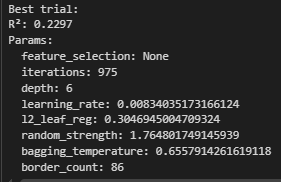
- 200 trials August 28, 2025

# Visualization

In [6]:
# 1. Parameter Importance Plot
fig = vis.plot_param_importances(study, target_name="R² Score")
fig.show()

# 2. Slice Plot (Best for seeing individual parameter effects)
fig = vis.plot_slice(
    study,
    params=[
        'iterations',
        'feature_selection',
        'depth',
        'learning_rate',
        'k_features'
    ],
    target_name="R² Score"
)
fig.show()

# Apply Feature Selection to Training & Test Data

In [7]:
# apply your feature selection code from before
best_fs_method = study.best_params.get('feature_selection', 'None')

if best_fs_method != 'None':
    k_features = study.best_params['k_features']
    if best_fs_method == 'RFE':
        estimator = RandomForestRegressor()
            #n_estimators=study.best_params.get('rfe_n_estimators', 100),
            #max_depth=study.best_params.get('rfe_max_depth', 5),
            #random_state=42
        selector = RFE(
            estimator, 
            n_features_to_select=k_features,
           # step=study.best_params.get('rfe_step', 1)
        )
    elif best_fs_method == 'MRMR':
        selector = MRMRTransformer(k_features=k_features)
    
    selector.fit(X, y)
    if hasattr(selector, 'get_support'):  # For SelectKBest/RFE
        selected_features = X.columns[selector.get_support()]
    else:  # For MRMRTransformer
        selected_features = selector.selected_features
    X_best = X[selected_features]
else:
    X_best = X
    selected_features = X.columns

# Apply the same feature selection to test data
if best_fs_method != 'None':
    if best_fs_method == 'MRMR':
        X_test_final = X_test[selected_features]
    else:
        X_test_final = selector.transform(X_test)  # Use the already fitted selector
        if isinstance(X_test, pd.DataFrame):
            X_test_final = pd.DataFrame(X_test_final, columns=selected_features)
else:
    X_test_final = X_test

# Create Catboost Model with Optimized Parameters and Fit Model

In [8]:
best_model = CatBoostRegressor(
    iterations=study.best_params['iterations'],
    depth=study.best_params['depth'],
    learning_rate=study.best_params['learning_rate'],
    l2_leaf_reg= study.best_params['l2_leaf_reg'],
    random_strength=study.best_params['random_strength'],
    bagging_temperature=study.best_params['bagging_temperature'],
    border_count=study.best_params['border_count'],
    random_seed = 42,
    verbose=False
)

# Train on full imputed data
best_model.fit(X_best, y)

# Run Model and Get Outcomes

In [9]:
# Make predictions
y_pred = best_model.predict(X_test_final)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\nFinal Model Evaluation on Test Set:")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

# Calculate accuracy within ±1 point
correct = np.sum(np.abs(y_test - y_pred) <= 1)
accuracy = correct / len(y_test)
print(f"Accuracy within ±1 point: {accuracy:.4f}")


Final Model Evaluation on Test Set:
RMSE: 1.1952
R²: 0.1099
Accuracy within ±1 point: 0.5375
